# Graph Analysis

### Connect with database

In [5]:
from neo4j import GraphDatabase

URI = "neo4j://localhost:7687"
NAME_DB = "neo4j"  # or "movies"

driver = GraphDatabase.driver(URI)

driver.verify_connectivity()
print("Successfully connected to Neo4j")

session = driver.session(database="system")

if [NAME_DB] in session.run("SHOW DATABASE yield name;").values():
    print("Database already exists")
else:
    session.run(f"CREATE DATABASE {NAME_DB};")
    print("Database created")
session = driver.session(database=NAME_DB)

Successfully connected to Neo4j
Database already exists


### Create constraints

In [18]:
# TODO: maybe add constraints for id for edges
session.run(
    """
    CREATE CONSTRAINT UniqueMovieID IF NOT EXISTS 
    FOR (m:Movie) 
    REQUIRE m.id IS unique;
    """
)
session.run(
    """
    CREATE CONSTRAINT UniqueUserID IF NOT EXISTS 
    FOR (u:User) 
    REQUIRE u.id IS unique;
    """
)
# TODO: add constraints for relationships

## Some other formatting

In [ ]:
session.run(
    """
MATCH ()-[t:TAGGED]->() SET t.timestamp = datetime({epochSeconds:toInteger(t.timestamp)});
"""
)

In [ ]:
session.run(
    """
MATCH ()-[r:RATED]->() SET r.timestamp = datetime({epochSeconds:toInteger(r.timestamp)});
"""
)

## Create Index

In [6]:
from graphdatascience import GraphDataScience

gds = GraphDataScience(URI, aura_ds=False, database=NAME_DB)
# total node counts
gds.run_cypher(
    """
    CALL apoc.meta.stats()
    YIELD labels AS nodeCounts
    UNWIND keys(nodeCounts) AS label
    WITH label, nodeCounts[label] AS nodeCount
    WHERE label IN ['User','Movie','Genre']
    RETURN label, nodeCount
"""
)

,label,nodeCount
0,Movie,86537
1,User,330975
2,Genre,20


In [7]:
gds.run_cypher(
    """
    CALL apoc.meta.stats()
    YIELD relTypesCount as relationshipCounts
    UNWIND keys(relationshipCounts) AS type
    WITH type, relationshipCounts[type] AS relationshipCount
    WHERE type IN ['RATED','TAGGED','IN_GENRE']
    RETURN type, relationshipCount
"""
)

,type,relationshipCount
0,TAGGED,2328315
1,IN_GENRE,152288
2,RATED,33832162


In [8]:
from typing import Union
import pandas as pd
import numpy as np


# Helper functions (https://github.com/zach-blumenfeld/demo-news-recommendation/blob/main/mind-large-collab-filtering/practical-graph-recommendation-cf-example.ipynb)
class GraphQueryError(Exception):
    def __init__(self, message):
        self.message = message


def run(driver, query, params=None):
    with driver.session() as session:
        if params is not None:
            return [r for r in session.run(query, params)]
        else:
            return [r for r in session.run(query)]


def degree_counts(
    node_label: str,
    relationship_type: str,
    direction: Union["IN", "OUT", "BOTH"] = "IN",
):

    match = f"(n:{node_label}) {'<' if direction in ['IN', 'BOTH'] else ''}-[:{relationship_type}]-{'>' if direction in ['OUT', 'BOTH'] else ''}()"

    df = gds.run_cypher(
        f"""
            MATCH {match}
            RETURN n.id as id,COUNT(*) AS degreeCount
            ORDER BY degreeCount DESC;
        """
    )
    return df


def get_percentiles(df, q=None):
    if q is None:
        q = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
    q_name = ["min"] + [f"p{int(100*i)}" for i in q] + ["max"]
    p = [df.min()] + [df[df.percentile >= i].iloc[0] for i in q] + [df.degree.max()]
    p_df = pd.DataFrame(np.column_stack((q_name, p)), columns=["q", "percentile"])
    return p_df.set_index("q")

/home/angelo-dev/miniconda3/envs/data_science/lib/python3.11/site-packages/graphdatascience/query_runner/neo4j_query_runner.py:224: RuntimeWarning: One of the property names in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing property name is: id)
  warnings.warn(warning)
/home/angelo-dev/miniconda3/envs/data_science/lib/python3.11/site-packages/graphdatascience/query_runner/neo4j_query_runner.py:224: RuntimeWarning: One of the property names in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing property name is: id)
  warnings.warn(warning)
/home/angelo-dev/miniconda3/envs/data_science/lib/python3.11/site-packages/graphdatascience/query_runner/neo4j_query_runner.py:224: RuntimeWarning: One of the property names in your query is not available in the 

<Axes: >

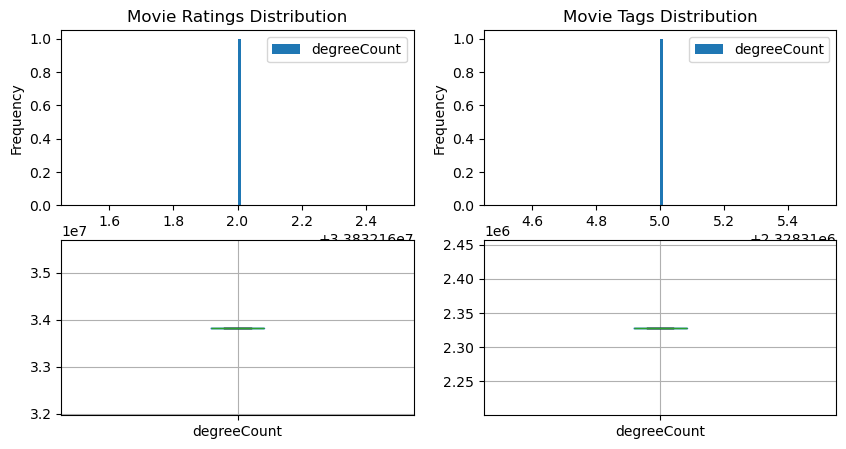

In [9]:
import matplotlib.pyplot as plt

all_ratings_df = degree_counts("Movie", "RATED", "IN")
all_tags_df = degree_counts("Movie", "TAGGED", "IN")
all_genres_df = degree_counts("Genre", "IN_GENRE", "IN")

# plot disributions
f, axs = plt.subplots(2, 2, figsize=(10, 5))

all_ratings_df.plot(
    x="id",
    y="degreeCount",
    kind="hist",
    ax=axs[0, 0],
    title="Movie Ratings Distribution",
    bins=100,
)
all_tags_df.plot(
    x="id",
    y="degreeCount",
    kind="hist",
    ax=axs[0, 1],
    title="Movie Tags Distribution",
    bins=100,
)

all_ratings_df.boxplot(column="degreeCount", ax=axs[1, 0])
all_tags_df.boxplot(column="degreeCount", ax=axs[1, 1])

In [10]:
all_ratings_df

,id,degreeCount
0,None,33832162
